In [ ]:
!git clone https://github.com/DeepWok/mase.git
%cd mase
!python3 -m pip install -e . -vvv

from google.colab import drive
drive.mount('/content/drive')

Removed build tracker: '/tmp/pip-build-tracker-zlv4li90'


KeyboardInterrupt: 

In [ ]:
import torch
torch.cuda.is_available()
# Output would be True if Pytorch is using GPU otherwise it would be False.

# Tutorial 4: Unstructured Pruning on Bert

Pruning is a technique used to reduce the size and complexity of neural networks by removing unnecessary parameters (weights and connections) or structural components (neurons, filters, or layers). The goal is to create a smaller, more efficient model that maintains most of the original model's performance. The following benefits can be seen from pruning neural networks:

- **Reduce model size**: Deep neural networks often have millions of parameters, leading to large storage requirements.

- **Decrease inference time**: Fewer parameters mean fewer computations, resulting in faster predictions.

- **Improve generalization**: Removing unnecessary connections can help prevent overfitting.

- **Energy efficiency**: Smaller models require less energy to run, which is crucial for edge devices and mobile applications.

Structured pruning removes entire structures (e.g., channels, filters, or layers) from the network, while unstructured pruning removes individual weights or connections from the network, regardless of their location. In this tutorial, we'll build on top of Tutorial 3 by taking the quantized Bert model and running Mase's unstructured pruning pass. After pruning, we'll run further fine tuning iterations to retain sequence classification accuracy in the pruned model.

In [ ]:
checkpoint = "prajjwal1/bert-tiny"
tokenizer_checkpoint = "bert-base-uncased"
dataset_name = "imdb"

## Importing the model

If you are starting from scratch, you can create a MaseGraph for Bert by running the following cell.

In [ ]:
from transformers import AutoModelForSequenceClassification

from chop import MaseGraph
import chop.passes as passes

model = AutoModelForSequenceClassification.from_pretrained(checkpoint)
model.config.problem_type = "single_label_classification"

mg = MaseGraph(
    model,
    hf_input_names=[
        "input_ids",
        "attention_mask",
        "labels",
    ],
)

mg, _ = passes.init_metadata_analysis_pass(mg)
mg, _ = passes.add_common_metadata_analysis_pass(mg)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at prajjwal1/bert-tiny and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
`past_key_values` were not specified as input names, but model.config.use_cache = True. Setting model.config.use_cache = False.
INFO     Getting dummy input for prajjwal1/bert-tiny.
/Users/yz10513/anaconda3/envs/mase/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


If you have previously ran the tutorial on Quantization-Aware Training (QAT), run the following cell to import the fine tuned checkpoint.

In [ ]:
import torch
from pathlib import Path
from chop import MaseGraph

# Verify CUDA
assert torch.cuda.is_available(), "Enable GPU in Colab: Runtime → Change runtime type → GPU"
print(f"Using GPU: {torch.cuda.get_device_name(0)}")

# Load checkpoint
mg = MaseGraph.from_checkpoint(
    checkpoint_path="/content/drive/MyDrive/Colab Notebooks/IC/Advanced Deep Learning/Lab 1/Tutorial 3/tutorial_3_qat",
    map_location=torch.device('cuda')
)

# Confirm model is on GPU
print(f"Model device: {next(mg.model.parameters()).device}")

Using GPU: NVIDIA L4


NameError: name 'MaseGraph' is not defined

In [ ]:
import torch
print(torch.cuda.is_available())  # Should return False in your case

from pathlib import Path
from chop import MaseGraph

mg = MaseGraph.from_checkpoint(f"/content/drive/MyDrive/Colab Notebooks/IC/Advanced Deep Learning/Lab 1/Tutorial 3/tutorial_3_qat")

True


/content/mase/src/chop/ir/graph/mase_graph.py:380: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_model = torch.load(f)


## Unstructured Pruning

Before running pruning, let's evaluate the model accuracy on the IMDb dataset. If you're coming from Tutorial, this would be the same as the accuracy after Quantization Aware Training (QAT). If you've just initialized the model, this will likely be a random guess (i.e. around 50%), in which case pruning wouldn't have a significant effect on the accuracy.

In [ ]:
from chop.tools import get_tokenized_dataset, get_trainer

dataset, tokenizer = get_tokenized_dataset(
    dataset=dataset_name,
    checkpoint=tokenizer_checkpoint,
    return_tokenizer=True,
)

trainer = get_trainer(
    model=mg.model,
    tokenized_dataset=dataset,
    tokenizer=tokenizer,
    evaluate_metric="accuracy",
)

# Evaluate accuracy
eval_results = trainer.evaluate()
print(f"Evaluation accuracy: {eval_results['eval_accuracy']}")

INFO     Tokenizing dataset imdb with AutoTokenizer for bert-base-uncased.
/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/7.81k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/21.0M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/20.5M [00:00<?, ?B/s]

unsupervised-00000-of-00001.parquet:   0%|          | 0.00/42.0M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

Map:   0%|          | 0/50000 [00:00<?, ? examples/s]

/content/mase/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Evaluation accuracy: 0.84268


To run the pruning pass, we pass the following pruning configuration dictionary, which defines the following parameters.

- **Sparsity**: a value between 0 and 1, expressing the proportion of elements in the model that should be pruned (i.e. set to 0).

- **Method**: several pruning methods are supported, including ``Random`` and ``L1-Norm``.

- **Scope**: defines whether to consider each weight/activation tensor individually (``local``) or all tensors in the model (``global``) when obtaining statistics for pruning (e.g. absolute value threshold for pruning)

We'll start by running random pruning with local scope, at a fixed sparsity. This may be suboptimal, but in future tutorials we'll see how to find optimal pruning and quantization configurations for a given model on a specified dataset.

In [ ]:
import chop.passes as passes

pruning_config = {
    "weight": {
        "sparsity": 0.5,
        "method": "l1-norm",
        "scope": "local",
    },
    "activation": {
        "sparsity": 0.5,
        "method": "l1-norm",
        "scope": "local",
    },
}

mg, _ = passes.prune_transform_pass(mg, pass_args=pruning_config)

INFO     Pruning module: bert_encoder_layer_0_attention_self_query
INFO     Pruning module: bert_encoder_layer_0_attention_self_key
INFO     Pruning module: bert_encoder_layer_0_attention_self_value
INFO     Pruning module: bert_encoder_layer_0_attention_output_dense
INFO     Pruning module: bert_encoder_layer_0_intermediate_dense
INFO     Pruning module: bert_encoder_layer_0_output_dense
INFO     Pruning module: bert_encoder_layer_1_attention_self_query
INFO     Pruning module: bert_encoder_layer_1_attention_self_key
INFO     Pruning module: bert_encoder_layer_1_attention_self_value
INFO     Pruning module: bert_encoder_layer_1_attention_output_dense
INFO     Pruning module: bert_encoder_layer_1_intermediate_dense
INFO     Pruning module: bert_encoder_layer_1_output_dense
INFO     Pruning module: bert_pooler_dense
INFO     Pruning module: classifier


Let's evaluate the effect of pruning on accuracy. It's likely to observe drops of around 10% or more.

In [ ]:
trainer = get_trainer(
    model=mg.model,
    tokenized_dataset=dataset,
    tokenizer=tokenizer,
    evaluate_metric="accuracy",
    num_train_epochs=5,
)

# Evaluate accuracy
eval_results = trainer.evaluate()
print(f"Evaluation accuracy: {eval_results['eval_accuracy']}")

/content/mase/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Evaluation accuracy: 0.70964


To overcome the drop in accuracy, we'll run a few finetuning epochs. This allows the model to adapt to the new pruning mask.

In [ ]:
trainer.train()

Step,Training Loss
500,0.453600
1000,0.419900
1500,0.431100
2000,0.413800
2500,0.407000
3000,0.417900
3500,0.419700
4000,0.401900
4500,0.384000
5000,0.393000


TrainOutput(global_step=15625, training_loss=0.3963747731933594, metrics={'train_runtime': 354.9159, 'train_samples_per_second': 352.196, 'train_steps_per_second': 44.025, 'total_flos': 0.0, 'train_loss': 0.3963747731933594, 'epoch': 5.0})

Let's evaluate the model accuracy after finetuning. We should see that the accuracy is reverted back to the original level.

In [ ]:
eval_results = trainer.evaluate()
print(f"Evaluation accuracy: {eval_results['eval_accuracy']}")

Evaluation accuracy: 0.83476


# Task

INFO     Tokenizing dataset imdb with AutoTokenizer for bert-base-uncased.
/content/mase/src/chop/ir/graph/mase_graph.py:380: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  l


=== Evaluating RANDOM pruning ===

Sparsity: 10%


/content/mase/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
500,0.469400
1000,0.432400
1500,0.444900
2000,0.414700
2500,0.410600
3000,0.430300


/content/mase/src/chop/ir/graph/mase_graph.py:380: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_model = torch.load(f)
INFO     Pruning module: bert_encoder_layer_0_a

random (10% sparsity) Accuracy: 0.8186

Sparsity: 20%


/content/mase/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
500,0.588200
1000,0.486900
1500,0.481500
2000,0.459800
2500,0.458700
3000,0.460000


/content/mase/src/chop/ir/graph/mase_graph.py:380: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_model = torch.load(f)
INFO     Pruning module: bert_encoder_layer_0_a

random (20% sparsity) Accuracy: 0.7990

Sparsity: 30%


/content/mase/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
500,0.682000
1000,0.648600
1500,0.567400
2000,0.518500
2500,0.518600
3000,0.506600


/content/mase/src/chop/ir/graph/mase_graph.py:380: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_model = torch.load(f)
INFO     Pruning module: bert_encoder_layer_0_a

random (30% sparsity) Accuracy: 0.7656

Sparsity: 40%


/content/mase/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
500,0.694600
1000,0.691400
1500,0.687100
2000,0.686000
2500,0.686200
3000,0.681600


/content/mase/src/chop/ir/graph/mase_graph.py:380: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_model = torch.load(f)
INFO     Pruning module: bert_encoder_layer_0_a

random (40% sparsity) Accuracy: 0.5845

Sparsity: 50%


/content/mase/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
500,0.695000
1000,0.694100
1500,0.691700
2000,0.693300
2500,0.693200
3000,0.691600


/content/mase/src/chop/ir/graph/mase_graph.py:380: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_model = torch.load(f)
INFO     Pruning module: bert_encoder_layer_0_a

random (50% sparsity) Accuracy: 0.5153

Sparsity: 60%


/content/mase/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
500,0.694100
1000,0.692600
1500,0.693200
2000,0.694000
2500,0.693200
3000,0.693400


/content/mase/src/chop/ir/graph/mase_graph.py:380: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_model = torch.load(f)
INFO     Pruning module: bert_encoder_layer_0_a

random (60% sparsity) Accuracy: 0.4988

Sparsity: 70%


/content/mase/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
500,0.693600
1000,0.692800
1500,0.693400
2000,0.693500
2500,0.692800
3000,0.693200


/content/mase/src/chop/ir/graph/mase_graph.py:380: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_model = torch.load(f)
INFO     Pruning module: bert_encoder_layer_0_a

random (70% sparsity) Accuracy: 0.4968

Sparsity: 80%


/content/mase/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
500,0.693300
1000,0.693300
1500,0.693200
2000,0.693200
2500,0.693100
3000,0.693300


/content/mase/src/chop/ir/graph/mase_graph.py:380: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_model = torch.load(f)
INFO     Pruning module: bert_encoder_layer_0_a

random (80% sparsity) Accuracy: 0.4955

Sparsity: 90%


/content/mase/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
500,0.693200
1000,0.693200
1500,0.693100
2000,0.693200
2500,0.693200
3000,0.693200


random (90% sparsity) Accuracy: 0.5015

=== Evaluating L1-NORM pruning ===

Sparsity: 10%


/content/mase/src/chop/ir/graph/mase_graph.py:380: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_model = torch.load(f)
INFO     Pruning module: bert_encoder_layer_0_a

Step,Training Loss
500,0.394800
1000,0.386800
1500,0.396700
2000,0.381300
2500,0.387300
3000,0.389600


/content/mase/src/chop/ir/graph/mase_graph.py:380: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_model = torch.load(f)
INFO     Pruning module: bert_encoder_layer_0_a

l1-norm (10% sparsity) Accuracy: 0.8478

Sparsity: 20%


/content/mase/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
500,0.390000
1000,0.384900
1500,0.392000
2000,0.375800
2500,0.381200
3000,0.382900


/content/mase/src/chop/ir/graph/mase_graph.py:380: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_model = torch.load(f)
INFO     Pruning module: bert_encoder_layer_0_a

l1-norm (20% sparsity) Accuracy: 0.8468

Sparsity: 30%


/content/mase/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
500,0.390700
1000,0.385800
1500,0.398200
2000,0.380700
2500,0.378300
3000,0.390300


/content/mase/src/chop/ir/graph/mase_graph.py:380: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_model = torch.load(f)
INFO     Pruning module: bert_encoder_layer_0_a

l1-norm (30% sparsity) Accuracy: 0.8414

Sparsity: 40%


/content/mase/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
500,0.412500
1000,0.392300
1500,0.408100
2000,0.392500
2500,0.389700
3000,0.404900


/content/mase/src/chop/ir/graph/mase_graph.py:380: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_model = torch.load(f)
INFO     Pruning module: bert_encoder_layer_0_a

l1-norm (40% sparsity) Accuracy: 0.8334

Sparsity: 50%


/content/mase/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
500,0.457500
1000,0.420700
1500,0.436800
2000,0.419500
2500,0.407400
3000,0.415800


/content/mase/src/chop/ir/graph/mase_graph.py:380: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_model = torch.load(f)
INFO     Pruning module: bert_encoder_layer_0_a

l1-norm (50% sparsity) Accuracy: 0.8176

Sparsity: 60%


/content/mase/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
500,0.545600
1000,0.460700
1500,0.460600
2000,0.440000
2500,0.430600
3000,0.433900


l1-norm (60% sparsity) Accuracy: 0.8047

Sparsity: 70%


/content/mase/src/chop/ir/graph/mase_graph.py:380: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_model = torch.load(f)
INFO     Pruning module: bert_encoder_layer_0_a

Step,Training Loss
500,0.653300
1000,0.616400
1500,0.587000
2000,0.557700
2500,0.541600
3000,0.527500


/content/mase/src/chop/ir/graph/mase_graph.py:380: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_model = torch.load(f)
INFO     Pruning module: bert_encoder_layer_0_a

l1-norm (70% sparsity) Accuracy: 0.7641

Sparsity: 80%


/content/mase/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
500,0.688500
1000,0.688300
1500,0.684200
2000,0.678500
2500,0.679900
3000,0.678700


/content/mase/src/chop/ir/graph/mase_graph.py:380: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_model = torch.load(f)
INFO     Pruning module: bert_encoder_layer_0_a

l1-norm (80% sparsity) Accuracy: 0.5757

Sparsity: 90%


/content/mase/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
500,0.693600
1000,0.693500
1500,0.693000
2000,0.693400
2500,0.693000
3000,0.692600


l1-norm (90% sparsity) Accuracy: 0.5046


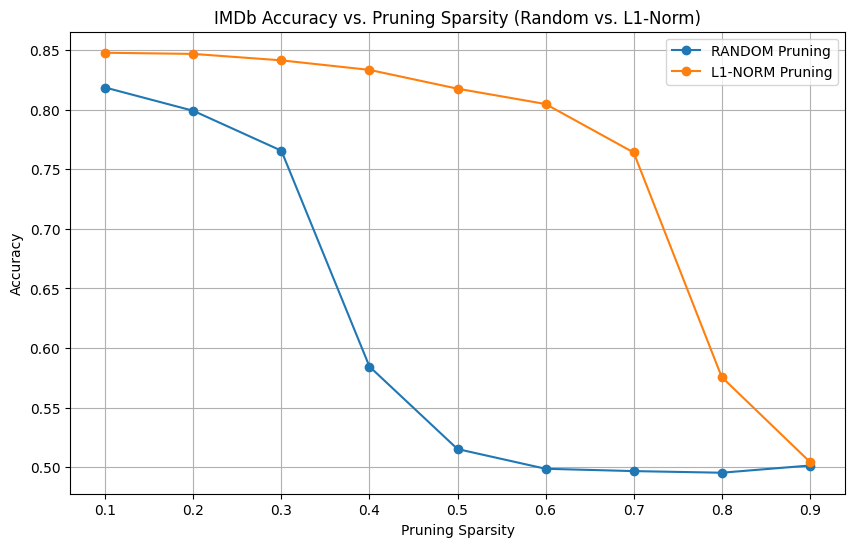

In [ ]:
import matplotlib.pyplot as plt
from chop import MaseGraph
import chop.passes as passes
from chop.tools import get_tokenized_dataset, get_trainer
from pathlib import Path

# Configuration (adjust paths as needed)
checkpoint_path = f"/content/drive/MyDrive/Colab Notebooks/IC/Advanced Deep Learning/Lab 1/Tutorial 3/tutorial_3_qat"  # Best model from Task 1
dataset_name = "imdb"
tokenizer_checkpoint = "bert-base-uncased"

# Load dataset and tokenizer once
dataset, tokenizer = get_tokenized_dataset(
    dataset=dataset_name,
    checkpoint=tokenizer_checkpoint,
    return_tokenizer=True,
)

# Define sparsity range and methods
sparsities = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
methods = ["random", "l1-norm"]
results = {method: [] for method in methods}

for method in methods:
    print(f"\n=== Evaluating {method.upper()} pruning ===")
    for sparsity in sparsities:
        print(f"\nSparsity: {sparsity:.0%}")

        # 1. Reload fresh model for each iteration
        mg = MaseGraph.from_checkpoint(checkpoint_path)

        # 2. Configure pruning
        pruning_config = {
            "weight": {
                "sparsity": sparsity,
                "method": method,
                "scope": "local"
            },
            "activation": {
                "sparsity": sparsity,
                "method": method,
                "scope": "local"
            }
        }

        # 3. Apply pruning
        mg, _ = passes.prune_transform_pass(mg, pass_args=pruning_config)

        # 4. Initialize trainer with QAT settings
        trainer = get_trainer(
            model=mg.model,
            tokenized_dataset=dataset,
            tokenizer=tokenizer,
            evaluate_metric="accuracy",
            num_train_epochs=4,
        )


        # 5. Fine-tune after pruning
        trainer.train()

        # 6. Evaluate final accuracy
        eval_results = trainer.evaluate()
        final_acc = eval_results["eval_accuracy"]
        results[method].append(final_acc)
        print(f"{method} ({sparsity:.0%} sparsity) Accuracy: {final_acc:.4f}")

# Plot results
plt.figure(figsize=(10, 6))
for method in methods:
    plt.plot(
        sparsities,
        results[method],
        marker="o",
        label=f"{method.upper()} Pruning"
    )

plt.xlabel("Pruning Sparsity")
plt.ylabel("Accuracy")
plt.title("IMDb Accuracy vs. Pruning Sparsity (Random vs. L1-Norm)")
plt.xticks(sparsities)
plt.legend()
plt.grid(True)
plt.show()